In [1]:
%matplotlib inline

In [2]:
from kid_readout.measurement import plot_basic
from kid_readout.measurement.io import npy

In [3]:
npd = npy.NumpyDirectory('/data/detectors/2016-12-13_135242_r1h11_lo_sweep.npd/')

In [25]:
print(npd.metadata.script_code)

"""
For each resonator, sweep the tone and filterbank frequencies across the resonance.

At each LO frequency, take one sweep and one streams at different places across the filterbank bin, moving the baseband
frequencies and LO frequency in opposite directions.
"""
import time

import numpy as np

from kid_readout.roach import analog, hardware_tools
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'r1h11_lo_sweep'
wait = 5
fft_gain = 3
num_tones_sweep = 255
f_minimum = 10e6  # Keep the tones away from the LO by at least this frequency.
df_lo_MHz = 2.5e-3  # Allegedly the minimum resolution
all_f0_MHz = np.array([2254.837, 2326.842, 2483.490, 3313.270, 3378.300, 3503.600, 3524.435])
f0 = all_f0_MHz[3:4]
attenuations = [33]
# The minimum for sweep resolution: gives 2 ** 5 tones per bin
tone_sample_exponent = 16
# This should s

In [4]:
npd.node_names()

['SingleSweepStream0',
 'ADCSnap1',
 'SingleSweepStream2',
 'ADCSnap3',
 'SingleSweepStream4',
 'ADCSnap5',
 'SingleSweepStream6',
 'ADCSnap7',
 'SingleSweepStream8',
 'ADCSnap9',
 'SingleSweepStream10',
 'ADCSnap11',
 'SingleSweepStream12',
 'ADCSnap13',
 'SingleSweepStream14',
 'ADCSnap15',
 'SingleSweepStream16',
 'ADCSnap17',
 'SingleSweepStream18',
 'ADCSnap19',
 'SingleSweepStream20',
 'ADCSnap21',
 'SingleSweepStream22',
 'ADCSnap23',
 'SingleSweepStream24',
 'ADCSnap25',
 'SingleSweepStream26',
 'ADCSnap27',
 'SingleSweepStream28',
 'ADCSnap29',
 'SingleSweepStream30',
 'ADCSnap31',
 'SingleSweepStream32',
 'ADCSnap33']

In [5]:
all_sss = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStream')]

In [6]:
[sss.stream.filterbank_bin for sss in all_sss]

[46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44]

In [7]:
sss_same = [sss for sss in all_sss if sss.stream.filterbank_bin == 45]

In [8]:
len(sss_same)

8

In [9]:
sss_same[0].resonator.Q_i

100186.29066039236

In [10]:
sss_same[0].resonator.Q_e_real

188024.35427902231

In [11]:
sss_same[0].resonator.Q_e_imag

-39050.976074073464

In [12]:
sss_same[0].resonator.f_0 / (2 * sss_same[0].resonator.Q)

24984.457318024946

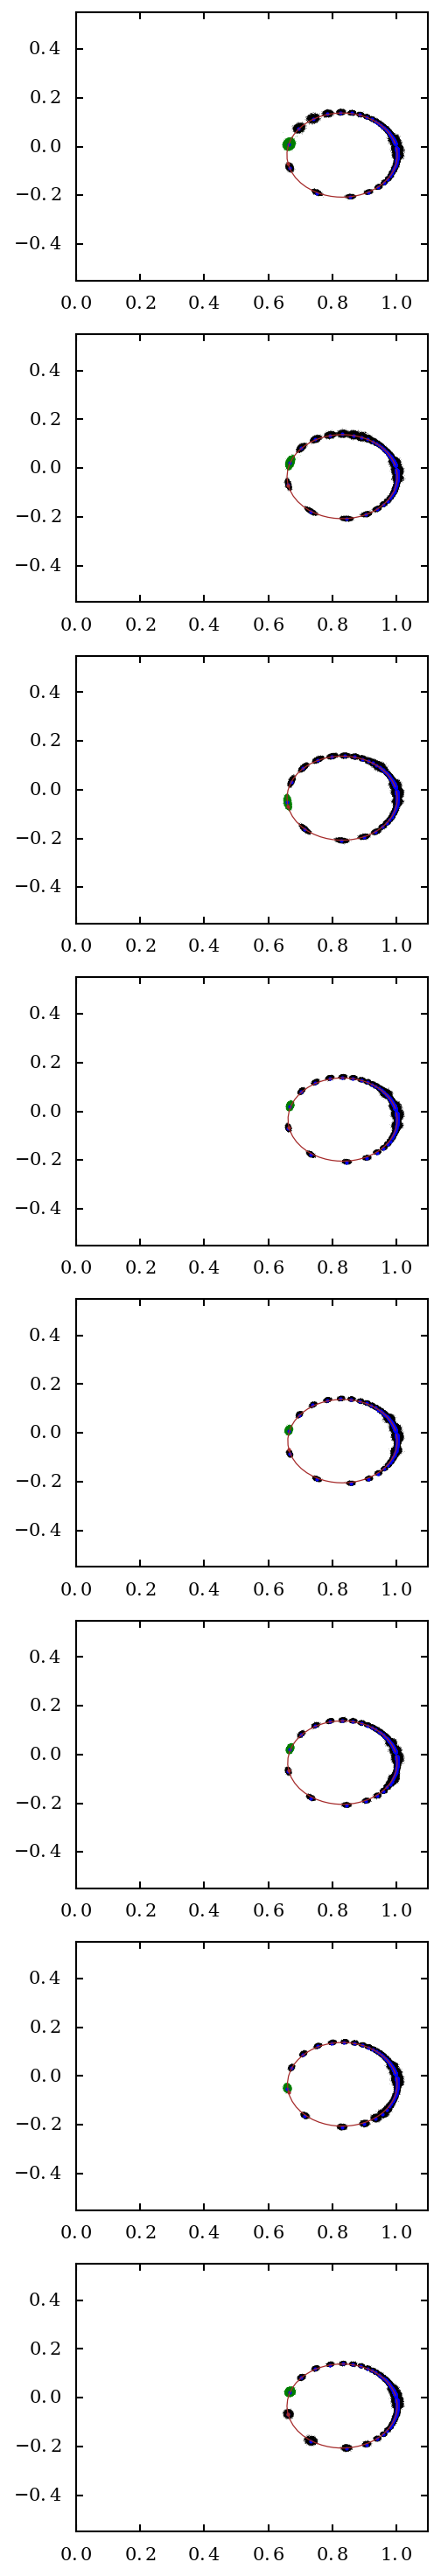

In [13]:
fig, axes = plt.subplots(len(sss_same), 1, figsize=(2, 2 * len(sss_same)))
for sss, ax in zip(sss_same, axes.flatten()):
    plot_basic.sss_complex_plane(sss, ax, normalize=True)
    ax.tick_params(labelsize=5)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(-0.55, 0.55);

In [14]:
[sss.stream.tone_offset_frequency()[0] for sss in sss_same]

[0.4375, 0.3125, 0.15625, 0.0625, -0.0625, -0.1875, -0.34375, -0.4375]

In [15]:
offset_mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-0.5, vmax=0.5),
                                        cmap=plt.cm.plasma)
offset_mappable.set_array(np.linspace(-0.5, 0.5, 3))

# All data

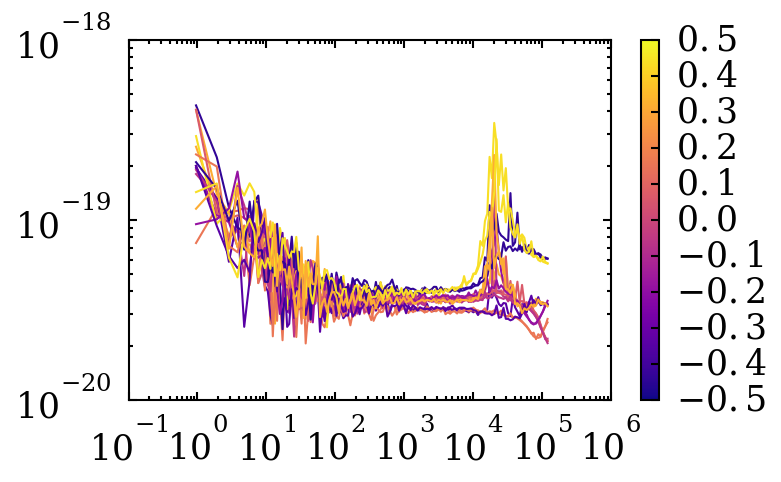

In [16]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for sss in all_sss:
    ax.plot(sss.S_frequency, sss.S_yy, color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)

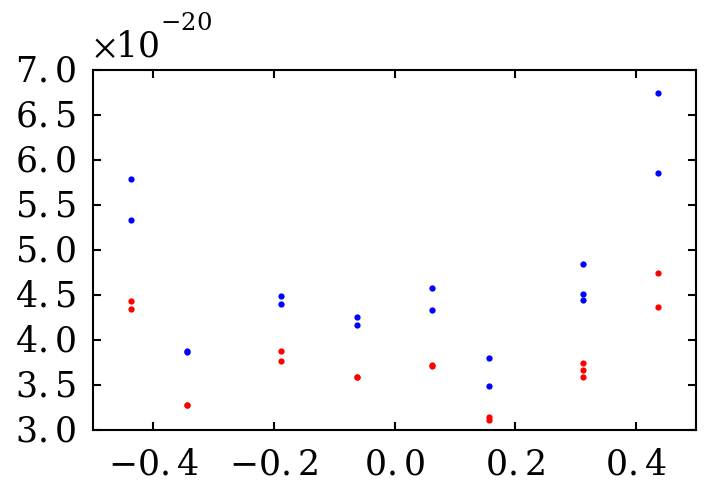

In [17]:
fig, ax = plt.subplots()
#ax.set_ylim(0, 1.6e-19)
for sss in all_sss:
    ax.plot(sss.stream.tone_offset_frequency(), 
            np.median(sss.S_yy),
            '.r')
    ax.plot(sss.stream.tone_offset_frequency(), 
            np.mean(sss.S_yy),
            '.b')

# Filterbank bin 45

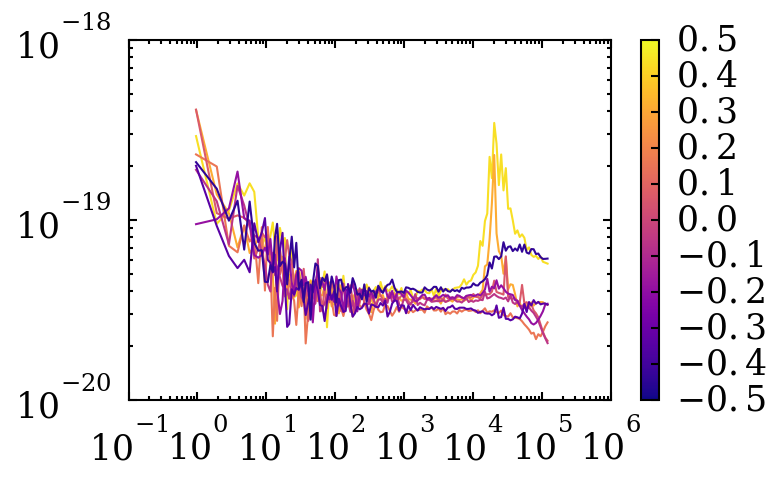

In [18]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for sss in sss_same:
    ax.plot(sss.S_frequency, sss.S_yy, color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)

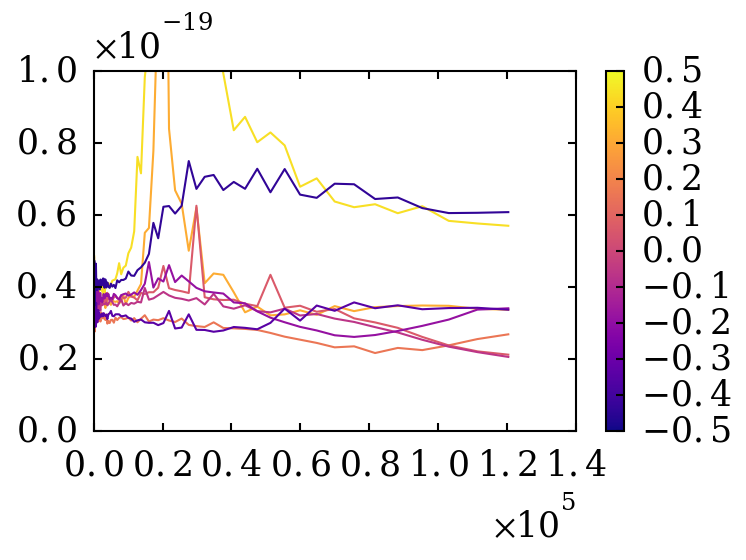

In [19]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1e-19)
for sss in sss_same:
    ax.plot(sss.S_frequency, sss.S_yy, color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)

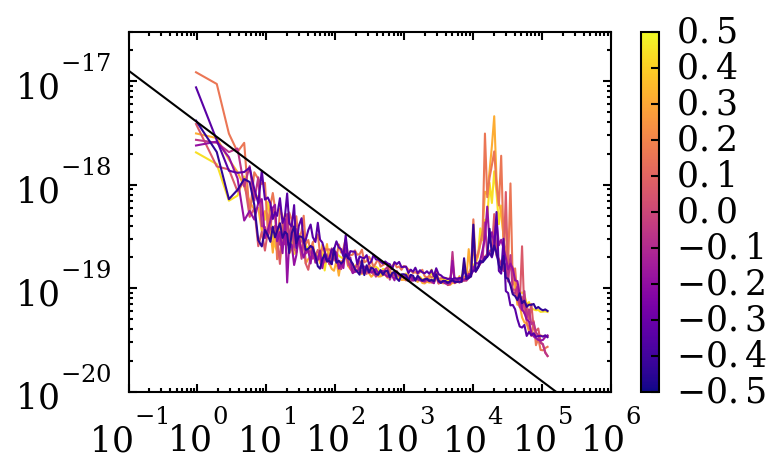

In [20]:
ff = np.logspace(-1, 6, 1000)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-20, 3e-17)
for sss in sss_same:
    ax.plot(sss.S_frequency, sss.S_xx, color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)
ax.plot(ff, 4e-18 * ff**(-1/2), '-k');

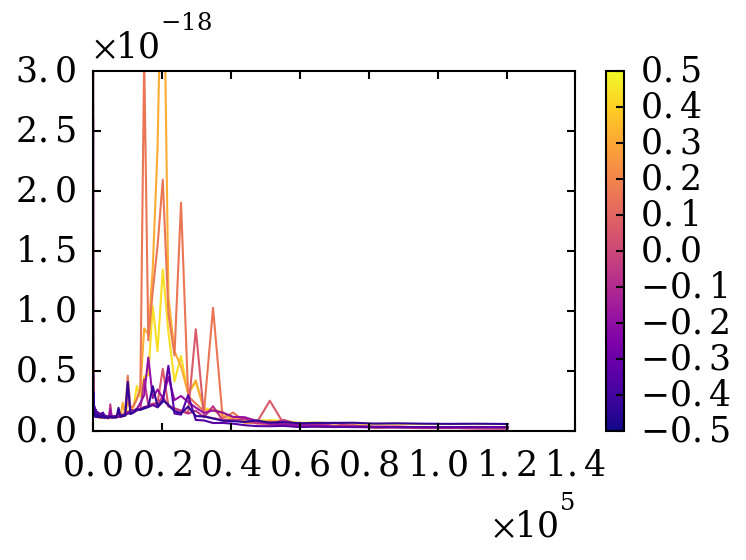

In [21]:
fig, ax = plt.subplots()
ax.set_ylim(0, 3e-18)
for sss in sss_same:
    ax.plot(sss.S_frequency, sss.S_xx, color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)

# Both

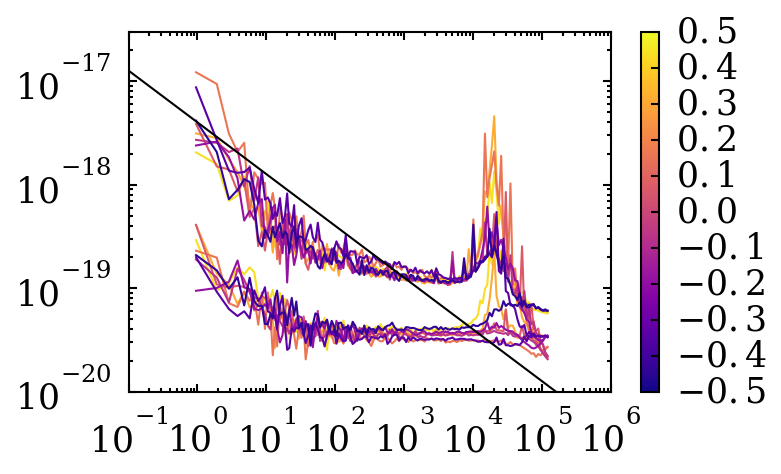

In [23]:
ff = np.logspace(-1, 6, 1000)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-20, 3e-17)
for sss in sss_same:
    ax.plot(sss.S_frequency, sss.S_xx, '-', color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
    ax.plot(sss.S_frequency, sss.S_yy, '-', color=offset_mappable.to_rgba(sss.stream.tone_offset_frequency()[0]))
fig.colorbar(mappable=offset_mappable, ax=ax)
ax.plot(ff, 4e-18 * ff**(-1/2), '-k');